### Entrenamiento de VGG usando CIFAR10 (from scratch)
CIFAR10 es un conjunto de datos etiquetados de imágenes pequeñas, contiene 60000 imágenes de colores de 32x32 divididas en 10 classes, son 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de prueba. Adaptado de: http://goo.gl/B68jj1

#### 1. Descargar y preprocesar CIFAR10 

In [1]:
from skdata.cifar10.dataset import CIFAR10
import numpy as np
import itertools as it

def batch_iterator(iterable, size, cycle=False, batch_fn=lambda x: x):
    """
    Generador en lotes de una lista o de un objeto iterable
    """
    batch = []

    if cycle is True:
        # volver al inicio
        iterable = it.cycle(iterable)

    # iterar sobre todos los elementos de la lista/iterable
    for item in iterable:
        batch.append(item)
        if len(batch) >= size:
            # generamos un lote de #_size_ elementos
            yield batch_fn(batch)
            batch = []

    if len(batch) > 0:
        # si hay restantes, para el último lote
        yield batch_fn(batch)


def get_cifar10(batch_size=16):
    print("cargando CIFAR10...")
   
    # dejemos a la librería skdata hacer su trabajo
    cifar10 = CIFAR10()
    cifar10.fetch(True)

    # cargamos toda la data en memoria 
    # entrenamiento:
    trn_labels = []
    trn_pixels = []
    for i in range(1, 6):
        data = cifar10.unpickle("data_batch_%d" % i)
        trn_pixels.append(data['data'])
        trn_labels.extend(data['labels'])
    trn_pixels = np.vstack(trn_pixels)
    trn_pixels = trn_pixels.reshape(-1, 3, 32, 32).astype(np.float32)
    # validación:
    tst_data = cifar10.unpickle("test_batch")
    tst_labels = tst_data["labels"]
    tst_pixels = tst_data["data"]
    tst_pixels = tst_pixels.reshape(-1, 3, 32, 32).astype(np.float32)

    # print("trn.shape=%s tst.shape=%s" % (trn_pixels.shape, tst_pixels.shape))

    print("estandarizando CIFAR10...")
    mu = np.mean(trn_pixels, axis=(0, 2, 3))
    std = np.std(trn_pixels, axis=(0, 2, 3))
    print("CIFAR10 mu  = %s" % mu)
    print("CIFAR10 std = %s" % std)    
    # x' = (x - u) / s
    trn_pixels[:, :, :, :] -= mu.reshape(1, 3, 1, 1)
    trn_pixels[:, :, :, :] /= std.reshape(1, 3, 1, 1)    
    tst_pixels[:, :, :, :] -= mu.reshape(1, 3, 1, 1)
    tst_pixels[:, :, :, :] /= std.reshape(1, 3, 1, 1)

    # usar orden de tensorflow: b x height x widht x canales
    trn_pixels = trn_pixels.transpose(0, 2, 3, 1)
    tst_pixels = tst_pixels.transpose(0, 2, 3, 1)
    
    print("trn_pixels", trn_pixels.shape)
    print("tst_pixels", tst_pixels.shape)

    # generador en lotes para la data de entrenamiento 
    trn_set = batch_iterator(it.cycle(zip(trn_pixels, trn_labels)), batch_size, cycle=True, batch_fn=lambda x: zip(*x))
    # todo el conjunto de validación
    tst_set = (np.vstack(tst_pixels), np.array(tst_labels))
    return trn_set, tst_set


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### 2. Definir el modelo y el algoritmo de entrenamiento

In [5]:
import tensorflow as tf


def conv_op(input_op, name, kw, kh, n_out, dw, dh):
    '''
    capa convolucional 
    kw, kw: kernel
    dw, dh: stride
    n_out: profundidad / número de filtros
    '''
    n_in = input_op.get_shape()[-1].value

    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(scope + "w",
                                 shape=[kh, kw, n_in, n_out],
                                 dtype=tf.float32,
                                 initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv = tf.nn.conv2d(input_op, kernel, (1, dh, dw, 1), padding='SAME')
        bias_init_val = tf.constant(0.0, shape=[n_out], dtype=tf.float32)
        biases = tf.Variable(bias_init_val, trainable=True, name='b')
        z = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        activation = tf.nn.relu(z, name=scope)
        return activation


def fc_op(input_op, name, n_out):
    '''
    capa densa
    '''
    n_in = input_op.get_shape()[-1].value

    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(scope + "w",
                                 shape=[n_in, n_out],
                                 dtype=tf.float32,
                                 initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(0.1, shape=[n_out], dtype=tf.float32), name='b')
        activation = tf.nn.relu_layer(input_op, kernel, biases, name=scope)
        return activation


def mpool_op(input_op, name, kh, kw, dh, dw):
    '''
    pooling
    '''
    return tf.nn.max_pool(input_op,
                          ksize=[1, kh, kw, 1],
                          strides=[1, dh, dw, 1],
                          padding='SAME',
                          name=name)


def loss_op(logits, labels, batch_size):
    '''
    calculamos el costo usando cross-entropy loss
    se busca minimizar el resultado de esta operación
    https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
    '''
    labels = tf.expand_dims(labels, 1)
    indices = tf.expand_dims(tf.range(0, batch_size, 1), 1)
    print(labels.shape)
    print(indices.shape)
    concated = tf.concat([indices, labels], 1)
    onehot_labels = tf.sparse_to_dense(concated, np.asarray([batch_size, 10]), 1.0, 0.0)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=onehot_labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    return loss


def evaluate_op(predictions, labels):
    """
    evaluando la calidad de las predicciones
    retorna el número de predicciones correctas
    """    
    # array de booleanos verdadero si predictions[i]=labels[i]
    correct = tf.nn.in_top_k(predictions, labels, 1)
    total_correct = tf.reduce_sum(tf.cast(correct, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    return accuracy, total_correct


def inference_cifar10_vgg(input_op, training=False):
    dropout_keep_prob = 1.0 if training else 1.0
    
    # block 1 -- outputs 112x112x64
    conv1_1 = conv_op(input_op, name="conv1_1", kh=3, kw=3, n_out=16, dh=1, dw=1)
    conv1_2 = conv_op(conv1_1, name="conv1_2", kh=3, kw=3, n_out=16, dh=1, dw=1)
    pool1 = mpool_op(conv1_2, name="pool1", kh=2, kw=2, dw=2, dh=2)

    # block 2 -- outputs 56x56x128
    conv2_1 = tf.nn.dropout(conv_op(pool1, name="conv2_1", kh=3, kw=3, n_out=32, dh=1, dw=1), dropout_keep_prob)
    conv2_2 = tf.nn.dropout(conv_op(conv2_1, name="conv2_2", kh=3, kw=3, n_out=32, dh=1, dw=1), dropout_keep_prob)
    pool2 = mpool_op(conv2_2, name="pool2", kh=2, kw=2, dh=2, dw=2)

    # block 3 -- outputs 28x28x256
    conv3_1 = tf.nn.dropout(conv_op(pool2, name="conv3_1", kh=3, kw=3, n_out=64, dh=1, dw=1), dropout_keep_prob)
    conv3_2 = tf.nn.dropout(conv_op(conv3_1, name="conv3_2", kh=3, kw=3, n_out=64, dh=1, dw=1), dropout_keep_prob)
    pool3 = mpool_op(conv3_2, name="pool3", kh=2, kw=2, dh=2, dw=2)

    # block 4 -- outputs 14x14x512
    conv4_1 = tf.nn.dropout(conv_op(pool3, name="conv4_1", kh=3, kw=3, n_out=128, dh=1, dw=1), dropout_keep_prob)
    conv4_2 = tf.nn.dropout(conv_op(conv4_1, name="conv4_2", kh=3, kw=3, n_out=128, dh=1, dw=1), dropout_keep_prob)
    conv4_3 = tf.nn.dropout(conv_op(conv4_2, name="conv4_3", kh=3, kw=3, n_out=128, dh=1, dw=1), dropout_keep_prob)
    pool4 = mpool_op(conv4_3, name="pool4", kh=2, kw=2, dh=2, dw=2)

    # flatten
    shp = pool4.get_shape()
    flattened_shape = shp[1].value * shp[2].value * shp[3].value
    resh1 = tf.reshape(pool4, [-1, flattened_shape], name="resh1")

    # fully connected
    fc6 = fc_op(resh1, name="fc6", n_out=1024)
    fc6_drop = tf.nn.dropout(fc6, dropout_keep_prob, name="fc6_drop")

    fc7 = fc_op(fc6_drop, name="fc7", n_out=1024)
    fc7_drop = tf.nn.dropout(fc7, dropout_keep_prob, name="fc7_drop")

    fc8 = fc_op(fc7_drop, name="fc8", n_out=10)
    softmax = tf.nn.softmax(fc8)
    predictions = tf.argmax(softmax, 1)
    return predictions, softmax, fc8


def train(trn_generator,
          val_generator,
          steps_per_epoch,
          lr=0.01,
          nb_epochs=10,
          batch_size=12,
          training_log_path="train_log.csv"):

    with tf.Graph().as_default():

        # las imágenes son reducidas al tamaño de entrada de la red
        raw_images = tf.placeholder("float", [batch_size, 32, 32, 3])
        images = tf.image.resize_images(raw_images, [128, 128])
        labels = tf.placeholder("int32", [batch_size])
        
        # el modelo de la red
        predictions, softmax, logits = inference_cifar10_vgg(images, training=True)
        # predictions, softmax, logits = inference_op(images, training=True)
        
        # la función objetivo a minimizar (costo)
        objective = loss_op(logits, labels, batch_size)
        
        # métrica de evaluación
        accuracy, total_correct = evaluate_op(softmax, labels)
        
        optimizer = tf.train.GradientDescentOptimizer(lr)
        # optimizer = tf.train.AdamOptimizer(lr)
        global_step = tf.Variable(0, name="global_step", trainable=False)
        train_step = optimizer.minimize(objective, global_step=global_step)

        # iniciando entrenamiento
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())

            training_log = open(training_log_path, "w")
            training_log.write("trn_loss,trn_acc\n")

            for epoch in range(nb_epochs):
                
                for step in range(steps_per_epoch):
                    # siguiente lote de datos
                    batch = list(trn_generator.__next__())
                    X = np.array(batch[0])
                    Y = np.array(batch[1])
                    result = sess.run(
                        [train_step, objective, accuracy, predictions],
                        feed_dict={
                            raw_images: X,
                            labels: Y,
                        }
                    )
                    # 0=none, 1=loss, 2=accuracy, 3=predictions
                    trn_loss = result[1]
                    trn_acc = result[2]

                    training_log.write("%s,%s\n" % (trn_loss, trn_acc))
                        
                    if step % 100 == 0:
                        print("epoch:%5d, step:%5d, trn_loss: %s, trn_acc: %s," % (epoch, step, trn_loss, trn_acc))



#### 3. Ejecutar el entrenamiento

In [3]:
batch_size = 20
trn_generator, val_generator = get_cifar10(batch_size=batch_size)

cargando CIFAR10...
estandarizando CIFAR10...
CIFAR10 mu  = [ 125.30690002  122.95014954  113.86599731]
CIFAR10 std = [ 62.9932518   62.08860397  66.70500946]
trn_pixels (50000, 32, 32, 3)
tst_pixels (10000, 32, 32, 3)


In [6]:
train(trn_generator, val_generator, steps_per_epoch=50000 // batch_size, batch_size=batch_size)

(20, 1)
(20, 1)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch:    0, step:    0, trn_loss: 2.3043, trn_acc: 0.15,
epoch:    0, step:  100, trn_loss: 2.2943, trn_acc: 0.15,
epoch:    0, step:  200, trn_loss: 2.27281, trn_acc: 0.15,
epoch:    0, step:  300, trn_loss: 2.37426, trn_acc: 0.3,
epoch:    0, step:  400, trn_loss: 2.07837, trn_acc: 0.2,
epoch:    0, step:  500, trn_loss: 2.16427, trn_acc: 0.2,
epoch:    0, step:  600, trn_loss: 1.85057, trn_acc: 0.3,
epoch:    0, step:  700, trn_loss: 1.8274, trn_acc: 0.4,
epoch:    0, step:  800, trn_loss: 1.84018, trn_acc: 0.3,
epoch:    0, step:  900, trn_loss: 1.73902, trn_acc: 0.35,
epoch:    0, step: 1000, trn_loss: 1.74077, trn_acc: 0.5,
epoch:    0, step: 1100, trn_loss: 1.59323, trn_acc: 0.45,
epoch:    0, step: 1200, trn_loss: 1.96258, trn_acc: 0.35,
epoch:    0, step: 1300, trn_loss: 1.6826, trn_acc: 0.4,
epoch:    0, step: 1400, trn_loss: 1.89185, trn_acc: 0.35,
epoch:    0, step: 1500, trn_loss: 1.

epoch:    5, step:  900, trn_loss: 0.397766, trn_acc: 0.85,
epoch:    5, step: 1000, trn_loss: 0.595113, trn_acc: 0.85,
epoch:    5, step: 1100, trn_loss: 0.435573, trn_acc: 0.95,
epoch:    5, step: 1200, trn_loss: 0.28122, trn_acc: 0.85,
epoch:    5, step: 1300, trn_loss: 0.265558, trn_acc: 0.9,
epoch:    5, step: 1400, trn_loss: 0.42928, trn_acc: 0.9,
epoch:    5, step: 1500, trn_loss: 0.041922, trn_acc: 1.0,
epoch:    5, step: 1600, trn_loss: 0.321146, trn_acc: 0.9,
epoch:    5, step: 1700, trn_loss: 0.170569, trn_acc: 1.0,
epoch:    5, step: 1800, trn_loss: 0.285542, trn_acc: 0.9,
epoch:    5, step: 1900, trn_loss: 0.0986431, trn_acc: 1.0,
epoch:    5, step: 2000, trn_loss: 0.160926, trn_acc: 0.9,
epoch:    5, step: 2100, trn_loss: 0.503665, trn_acc: 0.8,
epoch:    5, step: 2200, trn_loss: 0.328507, trn_acc: 0.85,
epoch:    5, step: 2300, trn_loss: 0.553207, trn_acc: 0.8,
epoch:    5, step: 2400, trn_loss: 0.337565, trn_acc: 0.9,
epoch:    6, step:    0, trn_loss: 0.21855, trn_acc:

#### 4. Plotear los resultados

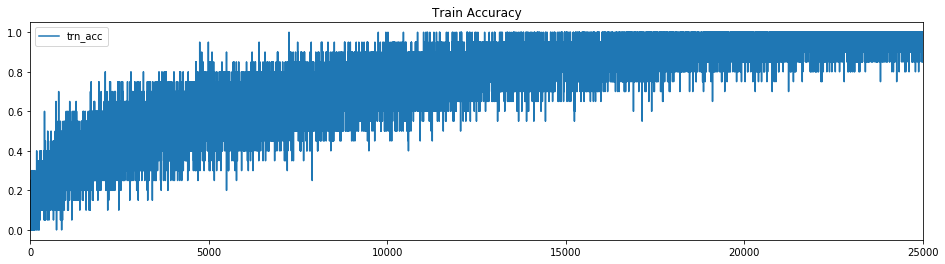

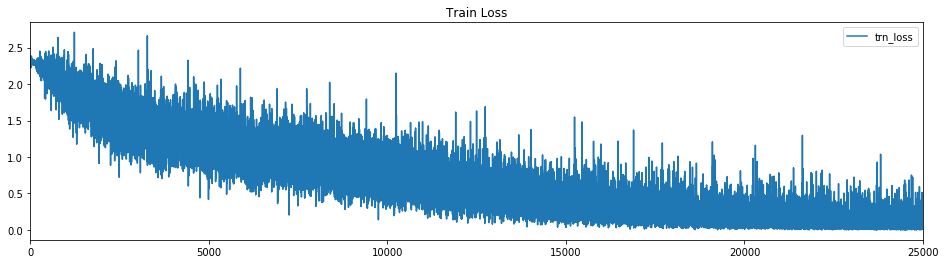

In [11]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('train_log.csv.1')
df.plot(y=['trn_acc'], figsize=(16,4), title='Train Accuracy')
df.plot(y=['trn_loss'], figsize=(16,4), title='Train Loss', )